In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, datasets
import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import wandb
import copy
import os
import math
import random
import numpy as np
import pandas as pd

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3
initial_lr = 1e-4
lr_backbone = 1e-5
batch_size = 64
num_epochs = 1
freeze_until_epoch = 10
checkpoint_path = "./checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

In [ ]:
weak_transform = transforms.Compose([
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
    
    
    transforms.RandomRotation(degrees=(-5, 5), interpolation=transforms.InterpolationMode.BILINEAR, expand=True, fill=0),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.005), transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
    
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True), # Resize maintaining aspect ratio, then pad to square
    transforms.RandomCrop(224), 

    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

strong_transform = transforms.Compose([
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
    
    transforms.RandomRotation(degrees=(-15, 15), interpolation=transforms.InterpolationMode.BILINEAR, expand=True, fill=0),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01), transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
    
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True), # Resize maintaining aspect ratio, then pad to square
    transforms.RandomCrop(224), 
    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True), # Resize maintaining aspect ratio, then pad to square
    transforms.CenterCrop(224), 
])


In [ ]:
image = Image.open("image.jpg").convert("RGB")

# Apply train_transform (as defined earlier)
transformed_image = strong_transform(strong_transform(image))

# Convert back to displayable format
img_to_show = F.to_pil_image(transformed_image)

# Display the image
plt.imshow(img_to_show)
plt.axis('off')
plt.title("Transformed Image")
plt.show()

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, csv_file, root_dir, weak_transform=None, strong_transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(self.root_dir,csv_file))
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')  
        original_label = self.annotations.iloc[idx, 1]
        label = torch.tensor(original_label + 1, dtype=torch.long)
        
        if self.weak_transform:
            weak_image = self.weak_transform(image)
        if self.strong_transform:
            strong_image = self.strong_transform(image)
            
        return weak_image, strong_image, label

class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(self.root_dir,csv_file))
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')  
        original_label = self.annotations.iloc[idx, 1]
        label = torch.tensor(original_label + 1, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_dataset = TrainDataset(csv_file="train.csv", root_dir=".\\data\\train", weak_transform=weak_transform, strong_transform=strong_transform)
val_dataset = ImageDataset(csv_file="val.csv", root_dir=".\\data\\val", transform=val_transform)
test_dataset = ImageDataset(csv_file="test.csv", root_dir=".\\data\\test", transform=val_transform)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# --- Mean Teacher Utilities ---
def update_ema_variables(model, ema_model, alpha, global_step):
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data, alpha=1 - alpha)

def compute_consistency_loss(student_outputs, teacher_outputs):
    return nn.functional.mse_loss(student_outputs, teacher_outputs.detach())

# --- Training Setup ---
model = ResNet50Classifier().to(device)
teacher_model = copy.deepcopy(model).to(device)
for p in teacher_model.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()

# Freeze conv1 manually
for p in model.backbone.conv1.parameters():
    p.requires_grad = False

# Separate param groups without overlaps
backbone_params = []
fc_params = []

for name, param in model.backbone.named_parameters():
    if name.startswith("fc."):
        fc_params.append(param)
    elif name.startswith("conv1."):
        continue  # Already frozen
    else:
        backbone_params.append(param)

optimizer = torch.optim.Adam([
    {'params': backbone_params, 'lr': lr_backbone},
    {'params': fc_params, 'lr': initial_lr},
])

# wandb.init(project="mean-teacher-image-classifier", config={
#     "epochs": num_epochs,
#     "batch_size": batch_size,
#     "lr": initial_lr,
#     "backbone_lr": lr_backbone
# })

In [ ]:
# --- Validation Function ---
def validate(model):
    model.eval()
    total, correct = 0, 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds)
            all_labels.append(y)
            total += y.size(0)
            correct += (preds == y).sum().item()
            for i in range(len(y)):
                class_total[y[i]] += 1
                class_correct[y[i]] += (preds[i] == y[i]).item()

    accuracy = correct / total
    class_recall = [class_correct[i] / class_total[i] if class_total[i] else 0 for i in range(num_classes)]
    # wandb.log({"val/accuracy": accuracy, "val/recall_good": class_recall[2],
    #            "val/recall_neutral": class_recall[1], "val/recall_bad": class_recall[0]})
    model.train()
    return accuracy

In [ ]:

# --- Training Loop ---
global_step = 0
for epoch in range(num_epochs):
    if epoch == freeze_until_epoch:
        for g in optimizer.param_groups:
            if g['lr'] == 0.0:
                g['lr'] = lr_backbone

    for x_weak, x_strong, y in train_loader:
        model.train()
        x_weak, x_strong, y = x_weak.to(device), x_strong.to(device), y.to(device)

        # Student forward
        student_outputs = model(x_strong)
        cls_loss = criterion(student_outputs, y)

        # Teacher forward
        with torch.no_grad():
            teacher_outputs = teacher_model(x_weak)

        consistency = compute_consistency_loss(student_outputs, teacher_outputs)
        loss = cls_loss + 0.5 * consistency

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_ema_variables(model, teacher_model, alpha=0.99, global_step=global_step)

        # wandb.log({"train/loss": loss.item(), "train/cls_loss": cls_loss.item(),
        #            "train/consistency": consistency.item(), "step": global_step})
        global_step += 1

    acc = validate(teacher_model)
    torch.save(model.state_dict(), f"{checkpoint_path}/student_epoch{epoch}.pth")
    torch.save(teacher_model.state_dict(), f"{checkpoint_path}/teacher_epoch{epoch}.pth")

# --- Inference Function ---
def infer(model_path, image_path):
    from PIL import Image
    model = ResNet50Classifier().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image = val_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = F.softmax(model(image), dim=1).squeeze().cpu().numpy()
    return {"bad": probs[0], "neutral": probs[1], "good": probs[2]}

# Example usage:
# print(infer("./checkpoints/teacher_epoch49.pth", "./data/sample.jpg"))

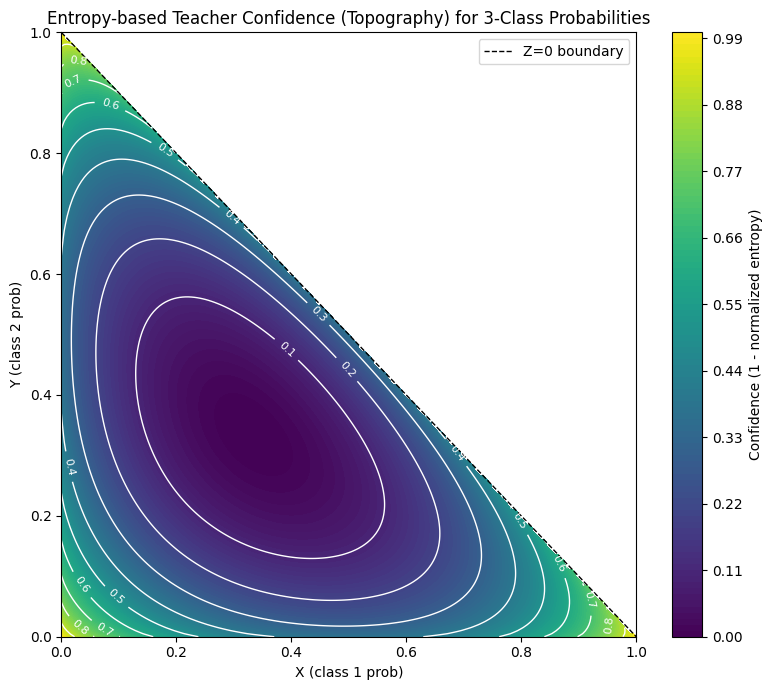

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def entropy_confidence(probs):
    """Compute entropy-based confidence = 1 - normalized entropy."""
    entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
    max_entropy = torch.log(torch.tensor(probs.shape[1], dtype=entropy.dtype))
    normalized_entropy = entropy / max_entropy
    confidence = 1.0 - normalized_entropy
    return confidence

# Create a grid of probabilities (X,Y,Z), with Z = 1 - X - Y
res = 200
X = np.linspace(0, 1, res)
Y = np.linspace(0, 1, res)
XX, YY = np.meshgrid(X, Y)
ZZ = 1 - XX - YY

# Mask invalid points (where Z < 0)
mask = (ZZ >= 0)
valid_points = np.stack([XX[mask], YY[mask], ZZ[mask]], axis=1)

# Compute confidence for valid (X,Y,Z)
probs = torch.tensor(valid_points, dtype=torch.float32)
conf = entropy_confidence(probs).numpy()

# Fill the grid with computed confidence values
CC = np.full_like(XX, np.nan)
CC[mask] = conf

# Plot
plt.figure(figsize=(8,7))
contourf = plt.contourf(XX, YY, CC, levels=100, cmap='viridis')
cbar = plt.colorbar(contourf, label='Confidence (1 - normalized entropy)')

# Add topographic contour lines for specific confidence levels
levels = np.arange(0.1, 1.0, 0.1)
contour_lines = plt.contour(XX, YY, CC, levels=levels, colors='white', linewidths=1)
plt.clabel(contour_lines, fmt="%.1f", colors='white', fontsize=8)

# Axis labels and decorations
plt.xlabel('X (class 1 prob)')
plt.ylabel('Y (class 2 prob)')
plt.title('Entropy-based Teacher Confidence (Topography) for 3-Class Probabilities')
plt.plot([0,1],[1,0], color='black', linestyle='--', linewidth=1, label='Z=0 boundary')
plt.legend()

plt.tight_layout()
plt.show()
